In [13]:
import torch
import torch.nn as nn
import numpy as np
from model import CNN, MLP, LogisticRegression, ResNet18
from torch.utils.data import DataLoader
from dataset import MNISTNoiseDataset
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms
from tqdm import tqdm

# Hyperparameters

batch_size = 18
learning_rate = 0.0008
epochs=5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_model = "models/model_40.pth.tar"

def train(model, optimizer, loss_fn, train_loader, epoch):
    model.train()
    loop = tqdm(train_loader, leave=True)
    correct = 0
    total = 0
    mean_loss = []
    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(device)
        y = y.to(device)
        out = model(x)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_loss.append(loss.item())
        correct += int(sum(out.argmax(axis=1) == y))
        total += y.size(0)

        loop.set_postfix(loss=loss.item())

    mean_losses = sum(mean_loss) / len(mean_loss)
    accu = 100. * (correct / total)
    print(f"Epoch[{epoch+1}]: Train Loss: {mean_losses}, Train Accuracy: {accu}")
    return mean_losses, accu
    

def test(model, loss_fn, test_loader, epoch):
    model.eval()
    loop = tqdm(test_loader, leave=True)
    correct = 0
    total = 0
    mean_loss = []
    with torch.no_grad():
        for batch_idx, (x,y) in enumerate(loop):
            x = x.to(device)
            y = y.to(device)
            out = model(x).squeeze(0)
            loss = loss_fn(out, y)
            
            mean_loss.append(loss.item())
            correct += int(sum(out.argmax(axis=1) == y))
            total += y.size(0)
            
            loop.set_postfix(loss=loss.item())
    
    mean_losses = sum(mean_loss) / len(mean_loss)
    accu = 100. * (correct / total)
    print(f"Epoch[{epoch+1}]: Test Loss: {mean_losses}, Test Accuracy: {accu}")
    return mean_losses, accu

def main():
    dataset = MNISTNoiseDataset("MNIST/X.pt", "noisyData/y_40.pt")
    test_dataset = datasets.MNIST(root='MNIST', train=False, transform=transforms.ToTensor(), download=False)
    train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()
    model = ResNet18()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    min_acc = 1000
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, loss_fn, train_loader, epoch)
        test_loss, test_acc = test(model, loss_fn, test_loader, epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        if test_acc < min_acc:
            min_acc = test_acc
            torch.save(model.state_dict(), save_model)
            
    torch.save(test_losses, "trainingInfo/40_loss_test.pt")
    torch.save(test_accuracies, "trainingInfo/40_acc_test.pt")
    torch.save(train_losses, "trainingInfo/40_loss_train.pt")
    torch.save(train_accuracies, "trainingInfo/40_acc_train.pt")

if __name__ == "__main__":
    main()

100%|██████████| 2334/2334 [00:50<00:00, 46.18it/s, loss=0.321]


Epoch[1]: Train Loss: 1.2126564495872, Train Accuracy: 57.25


100%|██████████| 556/556 [00:05<00:00, 107.78it/s, loss=0.685]


Epoch[1]: Test Loss: 0.7276674221745498, Test Accuracy: 76.86


100%|██████████| 2334/2334 [00:50<00:00, 46.08it/s, loss=0.982]


Epoch[2]: Train Loss: 1.0307863804016137, Train Accuracy: 62.247619047619054


100%|██████████| 556/556 [00:05<00:00, 106.10it/s, loss=0.756]


Epoch[2]: Test Loss: 0.7529617996631767, Test Accuracy: 77.53


100%|██████████| 2334/2334 [00:50<00:00, 45.90it/s, loss=1.54] 


Epoch[3]: Train Loss: 0.9441536585540984, Train Accuracy: 64.64761904761905


100%|██████████| 556/556 [00:05<00:00, 106.02it/s, loss=0.792]


Epoch[3]: Test Loss: 0.7456025011676679, Test Accuracy: 75.55


100%|██████████| 2334/2334 [00:51<00:00, 45.36it/s, loss=0.746]


Epoch[4]: Train Loss: 0.8736820012816222, Train Accuracy: 66.91904761904762


100%|██████████| 556/556 [00:05<00:00, 106.81it/s, loss=1.38] 


Epoch[4]: Test Loss: 1.0317280311271442, Test Accuracy: 61.86000000000001


100%|██████████| 2334/2334 [00:50<00:00, 45.82it/s, loss=0.75] 


Epoch[5]: Train Loss: 0.8035888173190466, Train Accuracy: 69.38571428571429


100%|██████████| 556/556 [00:05<00:00, 106.49it/s, loss=0.964]


Epoch[5]: Test Loss: 0.9248143139181377, Test Accuracy: 66.92


In [14]:
from dataset import MNISTTestDataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from model import CNN, MLP, LogisticRegression, ResNet18
test_data = MNISTTestDataset("MNIST/test.csv", transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [15]:
model = ResNet18()
model.load_state_dict(torch.load(save_model))
predictions = []
model.to(device)
model.eval()
with torch.no_grad():
    for (x) in test_loader:
        out = model(x.to(device))
        pred = out.argmax(axis=1)
        predictions.append(pred)

In [16]:
predictions = torch.cat(predictions)

In [17]:
import pandas as pd
sub = pd.DataFrame({"ImageId":range(1,28001), "Label":predictions.cpu().detach().numpy()})

In [18]:
sub.to_csv("sub_file.csv", index=None)

In [7]:
pd.read_csv("sub_file.csv")

,ImageId,Label
0,1,3
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [2]:
y_10 = torch.load("lossData/10_acc_resnet.pt")
y_20 = torch.load("lossData/20_acc_resnet.pt")
y_30 = torch.load("lossData/30_acc_resnet.pt")
y_40 = torch.load("lossData/40_acc_resnet.pt")
x = np.arange(5)

FileNotFoundError: [Errno 2] No such file or directory: 'lossData/10_acc_resnet.pt'

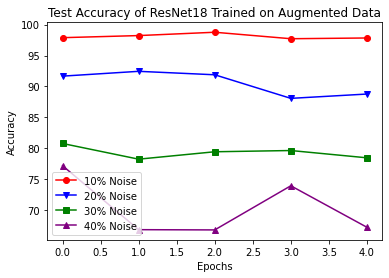

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(x, y_10, linestyle='-', marker='o', color='red', label='10% Noise')
ax.plot(x, y_20, linestyle='-', marker='v', color='blue', label='20% Noise')
ax.plot(x, y_30, linestyle='-', marker='s', color='green', label='30% Noise')
ax.plot(x, y_40, linestyle='-', marker='^', color='purple', label='40% Noise')
ax.legend()
ax.set_title('Test Accuracy of ResNet18 Trained on Augmented Data')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.show()

In [1]:
import torch

In [2]:
torch.load("lossData/10_acc_resnet.pt")

[97.98, 98.08, 98.52, 98.31, 97.8]

In [ ]:
""